# Deep Star Model V2 Visualization

In [1]:
import os, sys

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import loader, torch, torchvision

from torchvision import transforms
from PIL import Image, ImageDraw

from DeepStar.V2.Model import DeepStar
from Dijkstra.Dijkstra import *

tensor(1.0000)


## Visualization Settings

**Img Size**: Dimensions of the map to be used.<br>
**Save File**: Pytorch weight dictionary to load the network weights from.<br>
**Map FIle**: Image of the map to be used for visualization.<br>
**Seed**: GPU seed to use for computation.

In [2]:
img_size = (256, 256)
save_file = "Trained Models/deep_star_v5"
map_file = "data/images/map.png"
seed = 0

## Load Model

Load the specified deepstar model and set the seed.

In [3]:
torch.manual_seed(seed)

net = DeepStar()
net.load_state_dict(torch.load(save_file))

<All keys matched successfully>

## Data Visualization
### Helper Functions

**Guess To Point**<br>
Converts a normalized guess between [0 - 1] to a pixel value.<br>
**Return**: Pixel coordinate of the guess.

In [12]:
to_tensor = transforms.ToTensor()

def guess_to_point(g, img_size):
    return (round(g[0][0].item() * img_size[0]), round(g[0][1].item() * img_size[0]))

**Guess Point**<br>
Uses the loaded network to guess the midpoint between a start and a stop point. Start and Stop position will be normalized in the function.<br>
**Return**: A normalized guess at the midpoint on the map.

In [13]:
def guess_point(net, img, start, stop, img_size):
    img_tensor = to_tensor(img).unsqueeze(0)
    sx, sy = start
    ex, ey = stop
    
    sx = sx / img_size[0]
    sy = sy / img_size[1]
    
    ex = ex / img_size[0]
    ey = ey / img_size[1]
    
    pos_tensor = torch.FloatTensor([sx, sy, ex, ey]).unsqueeze(0)
    return guess_to_point(net(img_tensor, pos_tensor), img_size)

**Load World**<br>
Load a normalized heightmap world of nodes from a grayscale image.<br>
**Return**: 2D Normalized world array.

In [19]:
def load_world(img):
    world = []
    pixels = img.load()
    
    for x in range(img_size[0]):
        world.append([])
        for y in range(img_size[1]):
            if isinstance(pixels[x, y], int):
                value = pixels[x, y]
            else:
                value = pixels[x, y] if len(pixels[x, y]) == 1 else pixels[x, y][0]
                
            world[x].append(Node(float(value) / 255, (x, y)))
            
    return world

**Add Point**<br>
Add a point to a image with the given color.

In [6]:
def add_point(img, point, color_space):
    x, y = point
    img.paste(color_space, (x - 1, y - 1, x, y))

**Add Point**<br>
Add the start and endpoint to the image in their separate color channel.

In [ ]:
def add_points(img, start, end):
    sx, sy = start
    ex, ey = end
    
    img.paste((0, 255, 0), (sx - 1, sy - 1, sx, sy))
    img.paste((0, 0, 255), (ex - 1, ey - 1, ex, ey))

**Get Midpoints**<br>
Get a midpoint betwean each index pair in the path list.<br>
**Return**: A path with the midpoint for each index par inserted between them.

In [ ]:
def get_midpoints(net, path, start, stop):
    new_path = []
    
    for i in range(len(path) - 1):
        with Image.open(map_file) as img:
            g = guess_point(net, img.convert('L'), path[i], path[i + 1], img_size)
            new_path.append(g)
            
    return_path = []
    for i in range(len(path)):
        return_path.append(path[i])
        
        if (i < len(new_path)):
            return_path.append(new_path[i])
    
    return return_path

## Test Loaded Network

Gues midpoint between a start and a stop point, using the image specified in the settings at the beginning.

In [15]:
start = (128, 127)
stop = (123, 16)

with Image.open(map_file) as img:
    img = img.convert('L')
    guess = guess_point(net, img, start, stop, img_size)
    
    world = load_world(img)
    edges = get_edges(world)
    dijkstra_path = dijkstra(edges, start, stop)
    path = get_path(dijkstra_path)
    midpoint = get_path_midpoint(path)

    print(path[10])
    print(guess)

(123, 26)
(134, 68)


## Visualize Data Distribution

Visualize a data column in the csv file. Change the column name to view different data. Currently there is only three columns, Start, End and Midpoint.

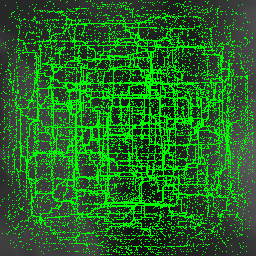

In [24]:
column_name = "Midpoint"

import pandas as pd
csv = pd.read_csv("data/images/data.csv", encoding = "UTF-8")

def to_tuple(t):
        return tuple(map(int, t.replace('(','').replace(')', '').split(', '))) 

with Image.open(map_file) as img:
    img = img.convert("RGB")
    for p in csv[column_name]:
        add_point(img, to_tuple(p), (0, 255, 0))
        
    display(img)

## Test Run On The Network

Test run on the selected mab between the start and stop point.

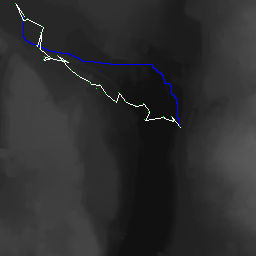

In [22]:
start = (180, 127)
stop = (24, 16)

path = [start, stop]

# Calculate the path using DeepStar
for i in range(5):
    path = get_midpoints(net, path, start, stop)

with Image.open(map_file) as img:
    # Load Image
    world = load_world(img)
    pixels = img.load()
    
    # Run djikstra on world loaded from image.
    img = img.convert("RGB")
    edges = get_edges(world)
    dijkstra_path = dijkstra(edges, start, stop)
    
    # Add djikstra path to image.
    for d in get_path(dijkstra_path):
        add_point(img, d, (0, 0, 255))
    
    # Draw lines between each pixel guessed by deepstar
    draw = ImageDraw.Draw(img)
    draw.line(path)
    
    del draw
    for p in path:
        add_point(img, p, (0, 255, 0))
    
    display(img)